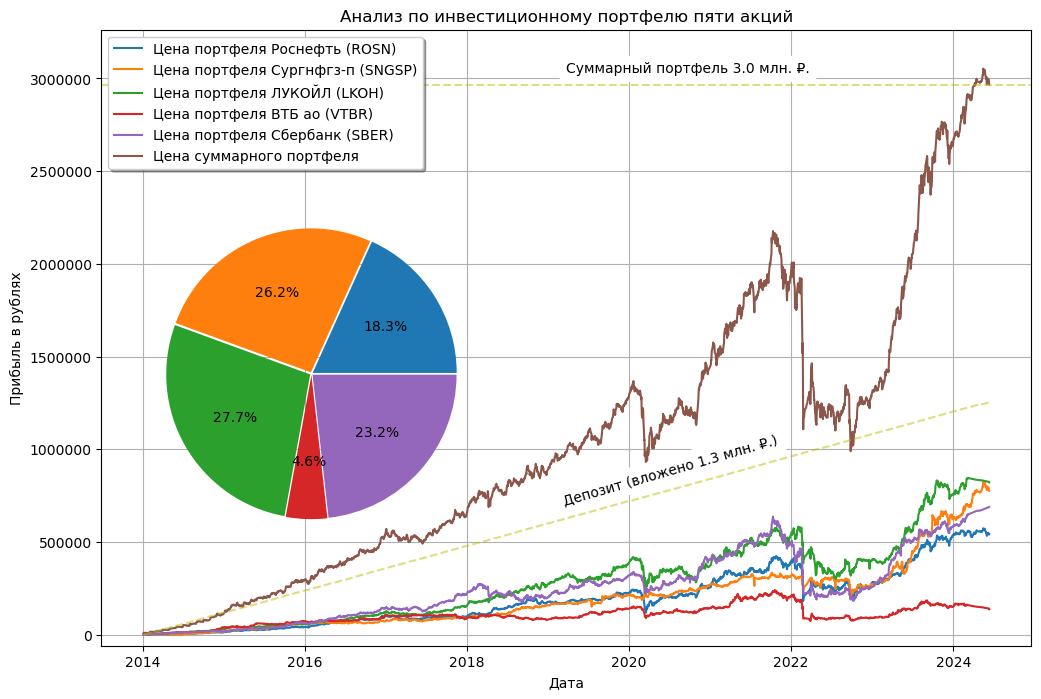

In [6]:
import os
import logging
import requests
import random
import datetime
import pandas as pd
import numpy as np
from typing import Text, List, Generator, Optional, Callable, Union
from functools import wraps
import multiprocessing
import concurrent.futures
import matplotlib.pyplot as plt

logger = multiprocessing.get_logger()


def log_init(logger: multiprocessing.get_logger = logger, 
             log_file_info: str = 'logs_info.txt', log_file_error: str = 'logs_err.txt', 
             out_stream: bool = 0, out_file_info: bool = 1, out_file_error: bool = 1) -> multiprocessing.get_logger:
    """ Настраиваем логгер """
    
    logger.setLevel(logging.INFO)
    log_formatter = logging.Formatter('{processName}, {asctime}, {message}', style='{')
    
    # Вывод в консоль
    if out_stream:
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(log_formatter)
        logger.addHandler(stream_handler)
    
    # INFO Вывод в файл
    if out_file_info:
        file_handler_info = logging.FileHandler(log_file_info, mode='w', encoding='UTF-8')
        file_handler_info.setFormatter(log_formatter)
        file_handler_info.setLevel(logging.INFO)
        logger.addHandler(file_handler_info)
    
    # ERROR Вывод в файл
    if out_file_error:
        file_handler_error = logging.FileHandler(log_file_error, mode='w', encoding='UTF-8')
        file_handler_error.setFormatter(log_formatter)
        file_handler_error.setLevel(logging.ERROR)
        logger.addHandler(file_handler_error)
    return logger


def log_decor(func: Callable, logger: multiprocessing.get_logger = logger): 
    """Логгер-декоратор"""
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        # получаем имя тикера из функции
        try:
            if isinstance(args[0], str) and args[0] == args[0].upper():
                ticker = f' ({args[0]})'
            else:
                ticker = ''
        except:
            ticker = ''
            
        # пробуем запустить функцию
        try:
            f = func(*args, **kwargs)
            logger.info(f'{func.__name__}{ticker} is done.')
            return f
        except Exception as exception:
            logger.error(f'{func.__name__}{ticker} is failed. Exception: {exception}.')
            raise exception
    return wrapper


@log_decor
def make_tickers_file(tickers: Optional[Text] = None, file: str = 'tickers.txt') -> None:
    """Создаем файл с тикерами компаний"""
    
    if not tickers:
        tickers = """SBER - Сбербанк
        SBERP - Сбербанк, привилегированные акции
        LKOH - Лукойл
        NVTK - Новатэк
        SIBN - Газпромнефть
        SNGS - Сургутнефтегаз
        SNGSP - Сургутнефтегаз, привилегированные акции
        PLZL - Полюс золото
        CHMF - Северсталь
        PHOR - ФосАгро
        AKRN - Акрон
        MGNT - Магнит
        GAZP - ГАЗПРОМ ао
        VTBR - ВТБ ао
        AFLT - Аэрофлот
        TATN - Татнфт 3ао
        ROSN - Роснефть
        MTSS - МТС-ао
        FEES - Россети
        KMAZ - КАМАЗ
        MSNG - +МосЭнерго
        ALRS - АЛРОСА ао
        AFKS - Система ао
        MOEX - Московская биржа"""
    
    with open(file, 'w') as f:
        f.write(tickers)


@log_decor
def get_ticker(file: str = 'tickers.txt', verbose=False) -> Generator:
    """Генератор 5ти случайных тикеров"""
    
    with open(file) as file:
        file = random.sample(list(file), k=5)
        for line in file:
            if verbose:
                print(line)
            ticker = line.strip().split(' - ')[0]
            yield ticker


@log_decor
def get_time_data_limits(ticker: str) -> List:
    """Получаем временной интервал для тикера"""
    url = (f'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/'
           f'{ticker}/dates.json')
    response = requests.get(url).json()
    time_data_limits = response['dates']['data'][0]
    return time_data_limits


@log_decor    
def get_prices(ticker: str, start: str, end: str, verbose=False) -> List[List]:
    """Запрос исторических цен"""

    start = datetime.datetime.strptime(start, "%Y-%m-%d").date()
    end = datetime.datetime.strptime(end, "%Y-%m-%d").date()
    if verbose:
        print(f'{ticker=}, {start=}, {end=}')
    start_date = start # save start for test check
    prices = []
    next_start = start
    while (next_start := next_start + datetime.timedelta(days=100)) <= end:
        url = (f'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/'
               f'{ticker}.json?from={start}&till={next_start}')
        response = requests.get(url).json()
        prices.extend(response['history']['data'])
        start = next_start + datetime.timedelta(days=1)
    columns = [column.lower() for column in response['history']['columns']]
    
    if (next_start - end).days > 0:
        next_start = end - datetime.timedelta(days=(next_start - end).days - 1)
        url = (f'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/'
               f'{ticker}.json?from={next_start}&till={end}')
        response = requests.get(url).json()
        prices.extend(response['history']['data'])
    
    assert len(set([tuple(item) for item in prices])) == len(prices), f'check duplicate {ticker}' 
    assert str(start_date) == prices[0][1] and str(end) == prices[-1][1], f'check lenght {ticker}' 
    return prices, columns


@log_decor
def get_dividends(ticker: str) -> List[List]:
    """Запрос дивидендных выплат"""

    url = f'http://iss.moex.com/iss/securities/{ticker}/dividends.json'
    response = requests.get(url).json()
    dividends = response['dividends']['data']
    columns = [column.lower() for column in response['dividends']['columns']]
    return dividends, columns    


@log_decor
def save_data(ticker: str, 
              prices: List[List], prices_columns: List, 
              dividends: List[List], dividends_columns: List,
              file: str = 'tickers_data.csv') -> None:
    """
    Присоединяем к данным тикера данные по диведентам (по общей дате) и
    сорраняем в единый csv файл в формате Pandas DataFrame.
    """
    
    prices = pd.DataFrame(prices, columns=prices_columns)
    prices['tradedate'] = pd.to_datetime(prices['tradedate'])
    dividends = pd.DataFrame(dividends, columns=dividends_columns)
    dividends['registryclosedate'] = pd.to_datetime(dividends['registryclosedate'])
    
    assert prices['secid'].iloc[0] == dividends['secid'].iloc[0] == ticker, f'check ticker name {ticker}'
    
    data = pd.merge(left=prices[['secid', 'tradedate', 'shortname', 'volume', 'close']],
                    right=dividends[['registryclosedate', 'value', 'currencyid']],
                    how='left',
                    left_on='tradedate',
                    right_on='registryclosedate')
    data.index = pd.to_datetime(data['tradedate'])
    data = (data[['secid', 'shortname', 'volume', 'close', 'value', 'currencyid']]
            .rename(columns={'value': 'dividends_value'}))
    data.to_csv(f'{ticker}_tickers_data.csv')

    
@log_decor
def pipeline(ticker: str) ->  str:
    """
    Последовательно выполняем: 
      - получаем данные о временных лимитах тикера
      - получаем все исторические данные тикера
      - получаем данные о дивидендах
      - преобразуем в единый Pandas DataFrame и сохраняем файл.
    """
    
    start_data, end_data = get_time_data_limits(ticker)
    ticker_prices, ticker_columns = get_prices(ticker, start_data, end_data)
    dividends_prices, dividends_columns = get_dividends(ticker)
    save_data(ticker, ticker_prices, ticker_columns, dividends_prices, dividends_columns)
    logger.info(f'{ticker} is downloaded and saved.')
    return ticker


@log_decor
def calc_tiсker_investment_portfolio(
            ticker: str,
            tickers_data: multiprocessing.Manager().list) ->  None:
    """
    Делаем расчет инвестиционного портфеля для отдельной акции:
    - каждый месяц покупаем акции на 2000 руб.
    - и покупаем акции на полученные дивиденды 
    """

    # загружаем данные акции
    share = pd.read_csv(f'{ticker}_tickers_data.csv')

    # переводим дату в datetime 
    share['tradedate'] = pd.to_datetime(share['tradedate'])
    share = share[share.tradedate >= '2014-1-1']
    
    # заменяем пропуски дивидендов нулями
    share[['dividends_value', 'currencyid']] = share[['dividends_value', 'currencyid']].fillna(0)
    
    # заменяем пропуски close линейной интерполяцией
    share['close'] = share['close'].interpolate(method='linear')
    share = share.dropna()
    
    # в начале каждого месяца покупаем акции каждого тикера на 10000 / 5 = 2000 руб 
    add_rub = 10000 / 5
    share['каждый месяц пополняем'] = (share['tradedate'].dt.month != share['tradedate'].dt.month.shift()) * add_rub
    
    # расчет количества акций
    number_of_shares = [0] * len(share)
    number_of_shares[0] = add_rub / share['close'].iloc[0]
    for i, columns in enumerate(share.values[1:], start=1):
        price_share_now = columns[4] # цена close
        dividends_value = columns[5] # дивиденды на акцию
        add_money_month = columns[7] # ежемесячная покупка
        
        # покупаем акции на дивиденды
        if dividends_value != 0:
            number_of_shares[i] = (number_of_shares[i-1] + 
                                  (number_of_shares[i-1] * dividends_value) / price_share_prev)
        
        # покупаем акции ежемесячно на 2000р 
        if add_money_month != 0:
            add = add_money_month / price_share_now
            # складываем с акциями от дивидендов если они были в этот день
            if dividends_value != 0:
                number_of_shares[i] = number_of_shares[i] + add
            else:
                number_of_shares[i] = number_of_shares[i-1] + add 
            
        # или количество акций остается прежним
        if add_money_month == 0 and dividends_value == 0:
            number_of_shares[i] = number_of_shares[i-1] 

        price_share_prev = price_share_now
        
    share['кол. акций'] = number_of_shares
    
    company_name = share['shortname'].iloc[0]
    share[f'Цена портфеля {company_name} ({ticker})'] = share['кол. акций'] * share['close']
    share = share.set_index('tradedate')
    
    # сохраняем данные в общий список
    tickers_data.append(share)
    

def investment_final_report(shares: List[str], show=True) ->  pd.DataFrame:
    """
    Объединяем инвестиционные портфели пяти акций.
    Строим график по каждой акции и общему портфелю. Считаем доли.
    """
    
    # создаем датафрейм в который будем добавлять портфели по акциям
    results = pd.DataFrame(index=pd.date_range(start=datetime.datetime.strptime('2014-1-1', "%Y-%m-%d"), 
                                               # end=datetime.datetime.strptime('2024-1-1', "%Y-%m-%d"),
                                               end=datetime.datetime.now(), 
                                               freq='D'))
    for share in shares:
        ticker = share['secid'].iloc[0]
        company = share['shortname'].iloc[0]
        results = results.join(share[[f'Цена портфеля {company} ({ticker})']], how='left')
    
    # убираем даты где небыло никаких данных, заменяем пропуски линейной интерполяцией 
    results = results.dropna(how='all').interpolate(method='linear')
    
    # если в начале периода акция еще не торговалась заполняем ценой депозита на одну акцию 2000р
    results = results.fillna(2000)
    
    # добавляем суммарный портфель по всем выбранным тикерам
    results[f'Цена cуммарного портфеля'] = results.sum(axis=1)

    
    # строим графики портфелей
    if show:
        fig = plt.figure(figsize=(12, 8))
        plt.plot(results)

        # добавляем линию суммы вложенных средств (вносилось 10000р каждый месяц)
        deposit = (results.index[-1] - results.index[0]).days / 30.4 * 10000
        x = results.index 
        y = np.linspace(0, deposit, len(results))
        plt.plot(x, y, color='y', linestyle='--', alpha=0.5)
        plt.text(x=x[len(x) // 2], y=y[len(y) // 2] + int(y[len(y) // 2]*0.1), 
                 s=f'Депозит (вложено {deposit/1e6:.01f} млн. ₽.)', 
                 ha='left', va='bottom',
                 transform_rotates_text=True, 
                 rotation=np.rad2deg(np.arctan2(y[-1], len(results)+1000)), 
                 rotation_mode='anchor', 
                 backgroundcolor='w')
        
        # добавляем линию суммарного профита
        total_profit = results.iloc[-1][-1]
        plt.axhline(y=total_profit, color='y', linestyle='--', alpha=0.5)
        plt.text(x=results.index[len(results) // 2], 
                 y=total_profit + int(total_profit*0.03), 
                 s=f'Суммарный портфель {total_profit/1e6:.01f} млн. ₽.', 
                 verticalalignment='center', backgroundcolor='w')
        
        plt.ticklabel_format(axis='y', style='plain', scilimits=(6, 6))
        plt.ylim(-int(total_profit*0.02), total_profit + int(total_profit*0.1))
        plt.xlabel('Дата')
        plt.ylabel('Прибыль в рублях')
        plt.title('Анализ по инвестиционному портфелю пяти акций')
        plt.legend(results.columns, loc='upper left', shadow=True, framealpha=1)
        plt.grid()
        plt.axes([0.15, 0.2, 0.3, 0.5])
        plt.pie(results.iloc[-1][:-1], autopct='%1.1f%%', explode=[0.01, 0.01, 0.01, 0.01, 0.01])
        plt.show()
    
    return results


if __name__ == '__main__':
    # создаем логгер
    logger = log_init()

    # создаем файл тикерами ценных бумаг
    make_tickers_file()

    # создаем список для сбора данных по тикерам
    tickers_data = multiprocessing.Manager().list()

    # запускаем обработку тикеров в многопроцессорном режиме
    with concurrent.futures.ProcessPoolExecutor() as executor:
        redownload = False
        futures = {}
        for ticker in get_ticker():
            if redownload or not os.path.isfile(f'{ticker}_tickers_data.csv'):
                # скачиваем и сохраняем данные тикера
                future = executor.submit(pipeline, ticker)
                # по готовности запускаем расчет стоимости портфеля для тикера
                future.add_done_callback(
                    lambda future: calc_tiсker_investment_portfolio(future.result(), tickers_data))
            else:
                # запускаем расчет стоимость портфеля для тикера если он уже скачен
                future = executor.submit(calc_tiсker_investment_portfolio, ticker, tickers_data)
            futures[future] = ticker
    # ждем результата
    concurrent.futures.wait(futures)

    # делаем финальный отчет стоимости портфелей для всех тикеров
    results = investment_final_report(tickers_data, show=True)